C:\Users\maraw\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


E:\Github\Pneumonia\Chest_X-Ray_Pneumonia_PyTorch


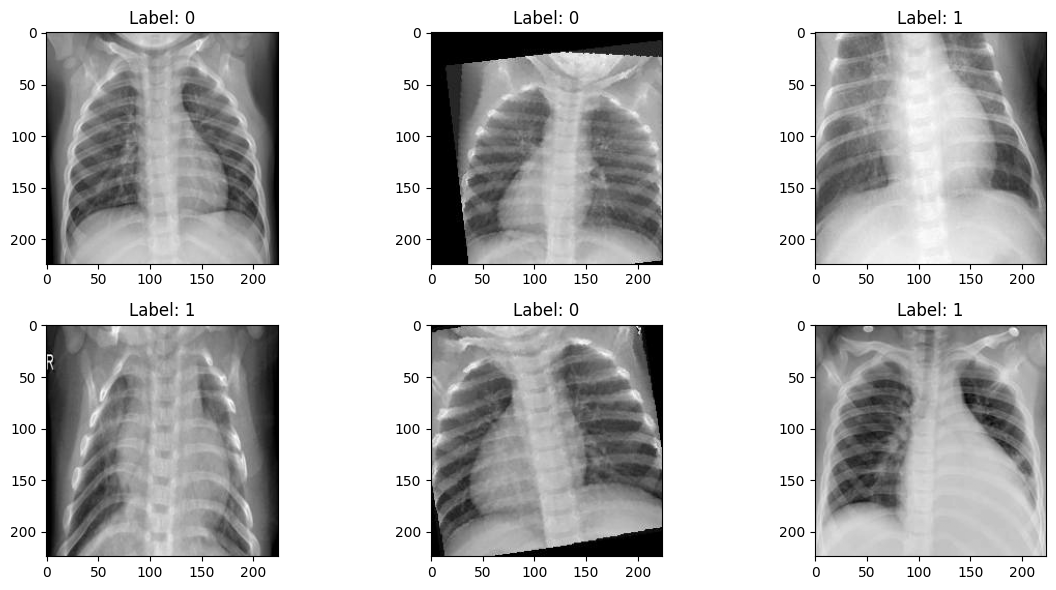

In [80]:
%run E:/Github/Pneumonia/Chest_X-Ray_Pneumonia_PyTorch/notebooks/Training/Loading_data.ipynb

# Importing libraries

In [81]:
from torchvision import transforms, models
from torch import nn
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.utils.class_weight import compute_class_weight

# Identifying the model

In [82]:
resnet = models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Modfying the architechture so it can fit our model

In [83]:
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

resnet.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

resnet

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Using the GPU in our training process

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
resnet = resnet.to(device)

Using device: cuda


# Creating an EarlyStopping function that monitors the validation loss 

In [85]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Identifying our Optimizer & Loss parameter

In [97]:
# Clarifying the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['clas']), y=df['clas'])
class_weights = class_weights.astype(np.float32)

# Optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# Assigning class weights
class_weights = torch.tensor(class_weights).to(device)

# Loss Function with class weights
loss = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

early_stopping = EarlyStopping(patience=20, min_delta=0.001)

# Training Loop

In [98]:
for epoch in tqdm(range(128)):
    # Training
    resnet.train()
    running_loss = 0.0
    train_corrects = 0
    train_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly
        
        optimizer.zero_grad()
        preds = resnet(images)  # No sigmoid here
        loss_val = loss(preds, labels)
        loss_val.backward()
        optimizer.step()

        running_loss += loss_val.item()

        # Convert predictions to binary (0 or 1) using 0.5 threshold
        predicted = (torch.sigmoid(preds) > 0.5).float()
        train_corrects += (predicted == labels).sum().item()
        train_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)

    # Validation
    resnet.eval()
    val_corrects = 0
    val_samples = 0
    val_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly
            preds = resnet(images)  # No sigmoid here
            loss_val = loss(preds, labels)
            val_loss += loss_val.item()

            # Convert predictions to binary (0 or 1)
            predicted = (torch.sigmoid(preds) > 0.5).float()
            val_corrects += (predicted == labels).sum().item()
            val_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_corrects / val_samples
    overall_acc = (train_corrects + val_corrects) / (train_samples + val_samples)
    f1 = f1_score(all_labels, all_preds, average='macro')  

    print(f"Epoch [{epoch+1}/128], "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_acc:.4f}, "
          f"Overall Accuracy: {overall_acc:.4f}, "
          f"F1 Score: {f1:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


  1%|          | 1/128 [01:37<3:26:09, 97.40s/it]

Epoch [1/128], Train Loss: 0.0064, Val Loss: 0.5630, Val Accuracy: 0.8125, Overall Accuracy: 0.9975, F1 Score: 0.8057


  2%|▏         | 2/128 [02:46<2:49:52, 80.90s/it]

Epoch [2/128], Train Loss: 0.0041, Val Loss: 2.3569, Val Accuracy: 0.6250, Overall Accuracy: 0.9978, F1 Score: 0.5636


  2%|▏         | 3/128 [03:54<2:35:39, 74.72s/it]

Epoch [3/128], Train Loss: 0.0009, Val Loss: 0.3990, Val Accuracy: 0.8750, Overall Accuracy: 0.9995, F1 Score: 0.8750


  3%|▎         | 4/128 [05:01<2:28:45, 71.98s/it]

Epoch [4/128], Train Loss: 0.0051, Val Loss: 0.8299, Val Accuracy: 0.6875, Overall Accuracy: 0.9981, F1 Score: 0.6537


  4%|▍         | 5/128 [06:18<2:30:37, 73.48s/it]

Epoch [5/128], Train Loss: 0.0057, Val Loss: 0.3730, Val Accuracy: 0.9375, Overall Accuracy: 0.9983, F1 Score: 0.9373


  5%|▍         | 6/128 [07:24<2:24:13, 70.93s/it]

Epoch [6/128], Train Loss: 0.0015, Val Loss: 0.3034, Val Accuracy: 0.8125, Overall Accuracy: 0.9992, F1 Score: 0.8057


  5%|▌         | 7/128 [08:31<2:20:29, 69.67s/it]

Epoch [7/128], Train Loss: 0.0002, Val Loss: 0.1156, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


  6%|▋         | 8/128 [09:39<2:18:42, 69.35s/it]

Epoch [8/128], Train Loss: 0.0015, Val Loss: 1.3158, Val Accuracy: 0.7500, Overall Accuracy: 0.9992, F1 Score: 0.7333


  7%|▋         | 9/128 [10:45<2:15:01, 68.08s/it]

Epoch [9/128], Train Loss: 0.0097, Val Loss: 0.3504, Val Accuracy: 0.8125, Overall Accuracy: 0.9970, F1 Score: 0.8118


  8%|▊         | 10/128 [11:49<2:11:53, 67.06s/it]

Epoch [10/128], Train Loss: 0.0042, Val Loss: 0.0165, Val Accuracy: 1.0000, Overall Accuracy: 0.9985, F1 Score: 1.0000


  9%|▊         | 11/128 [12:54<2:09:17, 66.31s/it]

Epoch [11/128], Train Loss: 0.0022, Val Loss: 0.3770, Val Accuracy: 0.8125, Overall Accuracy: 0.9989, F1 Score: 0.8057


  9%|▉         | 12/128 [14:14<2:16:02, 70.36s/it]

Epoch [12/128], Train Loss: 0.0023, Val Loss: 0.3602, Val Accuracy: 0.8750, Overall Accuracy: 0.9988, F1 Score: 0.8730


 10%|█         | 13/128 [15:35<2:21:03, 73.59s/it]

Epoch [13/128], Train Loss: 0.0005, Val Loss: 0.5442, Val Accuracy: 0.8125, Overall Accuracy: 0.9997, F1 Score: 0.8057


 11%|█         | 14/128 [16:59<2:25:56, 76.81s/it]

Epoch [14/128], Train Loss: 0.0064, Val Loss: 0.1225, Val Accuracy: 0.9375, Overall Accuracy: 0.9973, F1 Score: 0.9373


 12%|█▏        | 15/128 [18:21<2:27:48, 78.48s/it]

Epoch [15/128], Train Loss: 0.0056, Val Loss: 0.7786, Val Accuracy: 0.8125, Overall Accuracy: 0.9981, F1 Score: 0.8057


 12%|█▎        | 16/128 [19:45<2:29:14, 79.95s/it]

Epoch [16/128], Train Loss: 0.0016, Val Loss: 0.1314, Val Accuracy: 0.9375, Overall Accuracy: 0.9992, F1 Score: 0.9373


 13%|█▎        | 17/128 [21:11<2:31:27, 81.87s/it]

Epoch [17/128], Train Loss: 0.0018, Val Loss: 0.5875, Val Accuracy: 0.7500, Overall Accuracy: 0.9991, F1 Score: 0.7333


 14%|█▍        | 18/128 [22:27<2:26:46, 80.06s/it]

Epoch [18/128], Train Loss: 0.0002, Val Loss: 0.5823, Val Accuracy: 0.7500, Overall Accuracy: 0.9996, F1 Score: 0.7333


 15%|█▍        | 19/128 [23:37<2:20:12, 77.18s/it]

Epoch [19/128], Train Loss: 0.0000, Val Loss: 0.1429, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 16%|█▌        | 20/128 [24:51<2:16:53, 76.05s/it]

Epoch [20/128], Train Loss: 0.0000, Val Loss: 0.1774, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 16%|█▋        | 21/128 [26:21<2:23:14, 80.33s/it]

Epoch [21/128], Train Loss: 0.0000, Val Loss: 0.2279, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 17%|█▋        | 22/128 [28:12<2:38:18, 89.61s/it]

Epoch [22/128], Train Loss: 0.0000, Val Loss: 0.2577, Val Accuracy: 0.8750, Overall Accuracy: 0.9998, F1 Score: 0.8730


 18%|█▊        | 23/128 [29:41<2:36:24, 89.38s/it]

Epoch [23/128], Train Loss: 0.0000, Val Loss: 0.1559, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 19%|█▉        | 24/128 [31:08<2:33:56, 88.81s/it]

Epoch [24/128], Train Loss: 0.0000, Val Loss: 0.2032, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 20%|█▉        | 25/128 [32:19<2:23:09, 83.39s/it]

Epoch [25/128], Train Loss: 0.0000, Val Loss: 0.1842, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 20%|██        | 26/128 [33:30<2:15:13, 79.55s/it]

Epoch [26/128], Train Loss: 0.0000, Val Loss: 0.3973, Val Accuracy: 0.8125, Overall Accuracy: 0.9997, F1 Score: 0.8057


 21%|██        | 27/128 [34:41<2:09:40, 77.04s/it]

Epoch [27/128], Train Loss: 0.0000, Val Loss: 0.3354, Val Accuracy: 0.8750, Overall Accuracy: 0.9998, F1 Score: 0.8730


 22%|██▏       | 28/128 [35:51<2:04:40, 74.81s/it]

Epoch [28/128], Train Loss: 0.0000, Val Loss: 0.4811, Val Accuracy: 0.8750, Overall Accuracy: 0.9998, F1 Score: 0.8730


 23%|██▎       | 29/128 [37:02<2:01:37, 73.72s/it]

Epoch [29/128], Train Loss: 0.0000, Val Loss: 0.5804, Val Accuracy: 0.8125, Overall Accuracy: 0.9997, F1 Score: 0.8057


 23%|██▎       | 29/128 [38:12<2:10:26, 79.05s/it]

Epoch [30/128], Train Loss: 0.0000, Val Loss: 0.7151, Val Accuracy: 0.7500, Overall Accuracy: 0.9996, F1 Score: 0.7333
Early stopping triggered at epoch 30


# Evaluating my architecture

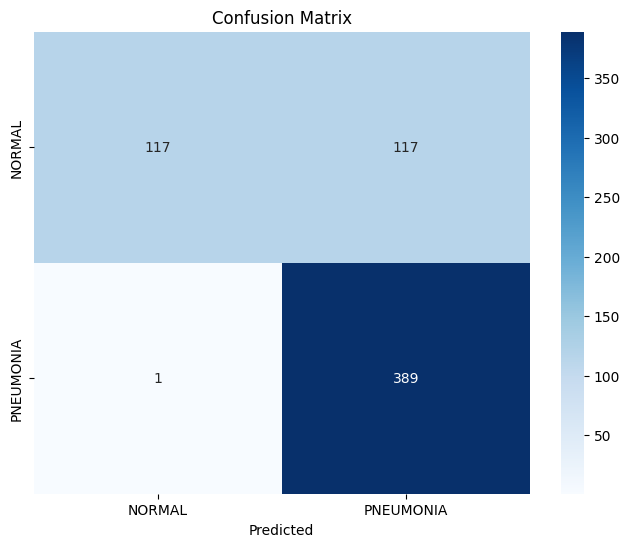

              precision    recall  f1-score   support

      NORMAL       0.99      0.50      0.66       234
   PNEUMONIA       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



In [99]:
from sklearn.metrics import classification_report, confusion_matrix

resnet.eval()
all_preds = []
all_labels = []

label_encoder = joblib.load('E:\Github\Pneumonia\Chest_X-Ray_Pneumonia_PyTorch\label_encoder.pkl')

with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(resnet(images))
        preds = (outputs > 0.5).long().squeeze()  # convert to 0/1 class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert numeric labels back to original class names
true_labels = label_encoder.inverse_transform(all_labels)
pred_labels = label_encoder.inverse_transform(all_preds)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.show()

# Classification report with readable labels
print(classification_report(true_labels, pred_labels))


# Saving my model

In [102]:
torch.save(resnet.state_dict(), r'E:\Github\Pneumonia\Chest_X-Ray_Pneumonia_PyTorch\models\resnet_binary_classification.pth')